In [12]:
import json, sys, os, glob, re
from os import listdir

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve, ShuffleSplit, train_test_split
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer

import warnings
warnings.filterwarnings("ignore")

In [25]:
%load_ext autoreload
%autoreload 2

sys.path.insert(0, 'src')
from helper import *
from eda import *
from train import *
from etl import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
# df = readfilerun_simple('data/raw/train_r/20220116T055105_20-100-true-20-100-iperf.csv')
# df = genfeat(readfilerun_simple('data/raw/switch/20220119T055428_300-500-true-300-5000-iperf.csv', 'data/raw/switch'))
df = genfeat(readfilerun_simple('data/jennawk5data/20220201T010740_200-100-true-200-10000-200-iperf.csv', 'data/jennawk5data'))

# df10 = agg10(df)
dfagg = better_agg(df)
dfagg.head()

NameError: name 'genfeat' is not defined

In [5]:
df['event'].unique()

array(['drop', nan, 'drop;drop', 'drop;drop;drop'], dtype=object)

In [6]:
ct = pd.read_csv('outputs/combined_transform.csv').rename(
    {'mean_tdelta.1': 'mean_tdelta_amin', 'mean_tdelta.2':'mean_tdelta_amax'}, 
    axis=1)
ct.head()

,total_bytes,max_bytes,max_bytes_std,Proto,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts,total_pkts,total_pkts_amin,...,mean_tdelta,mean_tdelta_amin,mean_tdelta_amax,max_tdelta,max_tdelta_amin,max_tdelta_amax,latency,loss,later_latency,later_loss
0,1254903.6,16261.6,4620.980252,6,1231800.0,23103.6,821.2,437.1,1258.3,784,...,0.764622,0.431958,1.233716,85.7,34,168,20,2000,20,2000
1,1725598.8,18534.0,9597.535841,6,1697400.0,28198.8,1131.6,539.7,1671.3,1440,...,0.599958,0.473884,0.694232,26.6,9,58,20,2000,20,2000
2,2036649.6,15224.8,2460.232184,6,2003550.0,33099.6,1335.7,633.0,1968.7,1695,...,0.511561,0.438133,0.586777,17.5,9,29,20,2000,20,2000
3,1773897.6,12337.2,1822.065299,6,1744500.0,29397.6,1163.0,561.6,1724.6,1512,...,0.580953,0.511329,0.660490,12.5,8,19,20,2000,20,2000
4,1809538.4,14474.4,2964.950335,6,1780200.0,29338.4,1186.8,561.2,1748.0,1485,...,0.575136,0.476533,0.673181,11.6,9,14,20,2000,20,2000


In [7]:
ct.columns

Index(['total_bytes', 'max_bytes', 'max_bytes_std', 'Proto', '1->2Bytes',
       '2->1Bytes', '1->2Pkts', '2->1Pkts', 'total_pkts', 'total_pkts_amin',
       'total_pkts_amax', 'number_ms', 'pkt_ratio', 'time_spread',
       'time_spread_amin', 'time_spread_amax', 'pkt sum', 'longest_seq',
       'longest_seq_amin', 'longest_seq_amax', 'total_pkt_sizes', 'byte_ratio',
       'mean_tdelta', 'mean_tdelta_amin', 'mean_tdelta_amax', 'max_tdelta',
       'max_tdelta_amin', 'max_tdelta_amax', 'latency', 'loss',
       'later_latency', 'later_loss'],
      dtype='object')

In [8]:
label_col = 'loss'
# indexcol = ['total_bytes', 'max_bytes', '2->1Bytes', '2->1Pkts', 'total_pkts',
#        'number_ms', 'pkt_ratio', 'time_spread', 'pkt sum', 'longest_seq',
#        'total_pkt_sizes', 'byte_ratio', 'mean_tdelta', 'max_tdelta']
# indexcol = ['total_bytes', 'max_bytes', 'max_bytes_std',
#        '2->1Bytes', '2->1Pkts', 'total_pkts', 'total_pkts_amin',
#        'total_pkts_amax', 'number_ms', 'pkt_ratio', 'time_spread',
#        'time_spread_amin', 'time_spread_amax', 'pkt sum', 'longest_seq',
#        'longest_seq_amin', 'longest_seq_amax', 'total_pkt_sizes', 'byte_ratio',
#        'mean_tdelta', 'mean_tdelta_amin', 'mean_tdelta_amax', 'max_tdelta',
#        'max_tdelta_amin', 'max_tdelta_amax']
# latency features
indexcol = ['byte_ratio', 'pkt_ratio', 'time_spread', 'total_bytes', '2->1Pkts']
# loss features
indexcol = ['total_pkts', 'total_pkt_sizes', '2->1Bytes', 'number_ms', 'mean_tdelta', 'max_tdelta'] 
    
# print(len(indexcol),df[[x for x in indexcol if x in df.columns]])

X_train, X_test, y_train, y_test = train_test_split(
    ct[[x for x in indexcol if x in df.columns]], ct[label_col])
# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
etree = RandomForestRegressor(n_estimators=400, n_jobs=4)
etreeft = etree.fit(X_train,y_train)

y_pred3 = etree.predict(X_test)
acc3= mean_squared_error(y_test, y_pred3)

print(f'mse: {acc3}, r2: {etree.score(X_test, y_test)}')
feat_imp = pd.Series(index=[x for x in indexcol if x in df.columns], 
          data=etree.feature_importances_).sort_values(ascending=False)
feat_imp

mse: 15149936.539837424, r2: 0.6519934955254453


2->1Bytes          0.559126
max_tdelta         0.143071
mean_tdelta        0.101740
number_ms          0.079518
total_pkts         0.060071
total_pkt_sizes    0.056474
dtype: float64

In [9]:
ct['total_pkts_amax']

0       1688
1       2107
2       2272
3       1943
4       2089
        ... 
7898    1533
7899    1452
7900    2187
7901    1871
7902    1354
Name: total_pkts_amax, Length: 7903, dtype: int64

In [ ]:
ct[['total_pkts_amax', 'total_pkts']].corr()

,total_pkts_amax,total_pkts
total_pkts_amax,1.000000,0.941817
total_pkts,0.941817,1.000000


In [11]:
dfr = df.reset_index(drop=True)
dfr

,Time,IP1,Port1,IP2,Port2,Proto,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts,...,pkt sum,longest_seq,mean_tdelta,max_tdelta,number_ms,max_bytes,total_pkt_sizes,pkt_ratio,time_spread,byte_ratio
0,1643677660,192.168.96.3,47330,192.168.48.2,5001,6,13664,60,11,1,...,13724,11,0.000000,0,1,13724,13724,1143.666667,0,1143.666667
1,1643677661,192.168.96.3,47330,192.168.48.2,5001,6,51000,1520,34,26,...,52520,3,13.694915,402,8,12284,52520,875.333333,808,875.333333
2,1643677662,192.168.96.3,47330,192.168.48.2,5001,6,42000,1456,28,28,...,43456,2,7.400000,399,9,10916,43456,776.000000,407,776.000000
3,1643677663,192.168.96.3,47330,192.168.48.2,5001,6,63000,1196,42,23,...,64196,3,12.656250,400,11,9156,64196,987.630769,810,987.630769
4,1643677664,192.168.96.3,47330,192.168.48.2,5001,6,42000,728,28,14,...,42728,2,9.878049,399,7,15260,42728,1017.333333,405,1017.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,1643677957,192.168.96.3,47330,192.168.48.2,5001,6,1807500,24232,1205,466,...,1831732,10,0.583234,33,243,27312,1831732,1096.189108,974,1096.189108
298,1643677958,192.168.96.3,47330,192.168.48.2,5001,6,1576500,21788,1051,419,...,1598288,7,0.675970,36,199,27312,1598288,1087.270748,993,1087.270748
299,1643677959,192.168.96.3,47330,192.168.48.2,5001,6,2160000,29224,1440,562,...,2189224,8,0.493253,34,223,27364,2189224,1093.518482,987,1093.518482
300,1643677960,192.168.96.3,47330,192.168.48.2,5001,6,1881000,26884,1254,517,...,1907884,8,0.554802,35,210,27416,1907884,1077.291925,982,1077.291925


In [12]:
dfp = dfr
dfr['prediction'] = etree.predict(dfr[indexcol].rolling(10).mean().bfill()) # prediction

dfr

,Time,IP1,Port1,IP2,Port2,Proto,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts,...,longest_seq,mean_tdelta,max_tdelta,number_ms,max_bytes,total_pkt_sizes,pkt_ratio,time_spread,byte_ratio,prediction
0,1643677660,192.168.96.3,47330,192.168.48.2,5001,6,13664,60,11,1,...,11,0.000000,0,1,13724,13724,1143.666667,0,1143.666667,103.75
1,1643677661,192.168.96.3,47330,192.168.48.2,5001,6,51000,1520,34,26,...,3,13.694915,402,8,12284,52520,875.333333,808,875.333333,103.75
2,1643677662,192.168.96.3,47330,192.168.48.2,5001,6,42000,1456,28,28,...,2,7.400000,399,9,10916,43456,776.000000,407,776.000000,103.75
3,1643677663,192.168.96.3,47330,192.168.48.2,5001,6,63000,1196,42,23,...,3,12.656250,400,11,9156,64196,987.630769,810,987.630769,103.75
4,1643677664,192.168.96.3,47330,192.168.48.2,5001,6,42000,728,28,14,...,2,9.878049,399,7,15260,42728,1017.333333,405,1017.333333,103.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,1643677957,192.168.96.3,47330,192.168.48.2,5001,6,1807500,24232,1205,466,...,10,0.583234,33,243,27312,1831732,1096.189108,974,1096.189108,8427.50
298,1643677958,192.168.96.3,47330,192.168.48.2,5001,6,1576500,21788,1051,419,...,7,0.675970,36,199,27312,1598288,1087.270748,993,1087.270748,8700.00
299,1643677959,192.168.96.3,47330,192.168.48.2,5001,6,2160000,29224,1440,562,...,8,0.493253,34,223,27364,2189224,1093.518482,987,1093.518482,8367.50
300,1643677960,192.168.96.3,47330,192.168.48.2,5001,6,1881000,26884,1254,517,...,8,0.554802,35,210,27416,1907884,1077.291925,982,1077.291925,11840.00


In [ ]:
dfr['event'].unique()

array(['drop', nan, 'drop;drop', 'drop;drop;drop'], dtype=object)

In [ ]:
dfr[~dfr['event'].isnull()]

,Time,IP1,Port1,IP2,Port2,Proto,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts,...,longest_seq,mean_tdelta,max_tdelta,number_ms,max_bytes,total_pkt_sizes,pkt_ratio,time_spread,byte_ratio,prediction
0,1643677660,192.168.96.3,47330,192.168.48.2,5001,6,13664,60,11,1,...,11,0.000000,0,1,13724,13724,1143.666667,0,1143.666667,105.250
5,1643677665,192.168.96.3,47330,192.168.48.2,5001,6,57000,1072,38,19,...,4,15.214286,352,10,15208,58072,1018.807018,852,1018.807018,105.250
6,1643677666,192.168.96.3,47330,192.168.48.2,5001,6,27000,808,18,13,...,5,23.500000,356,8,6244,27808,897.032258,705,897.032258,105.250
11,1643677671,192.168.96.3,47330,192.168.48.2,5001,6,78000,1144,52,22,...,4,12.150685,153,19,9104,79144,1069.513514,887,1069.513514,102.625
16,1643677676,192.168.96.3,47330,192.168.48.2,5001,6,99000,1852,66,34,...,4,9.787879,92,24,9156,100852,1008.520000,969,1008.520000,151.750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,1643677920,192.168.96.3,47330,192.168.48.2,5001,6,2085000,30448,1390,574,...,9,0.499745,55,257,31968,2115448,1077.112016,981,1077.112016,13457.500
263,1643677923,192.168.96.3,47330,192.168.48.2,5001,6,2032500,29356,1355,559,...,8,0.499739,53,237,35072,2061856,1077.249739,956,1077.249739,13330.000
273,1643677933,192.168.96.3,47330,192.168.48.2,5001,6,1470000,20552,980,377,...,10,0.733776,49,216,27364,1490552,1098.417097,995,1098.417097,12332.500
282,1643677942,192.168.96.3,47330,192.168.48.2,5001,6,1990500,28964,1327,557,...,8,0.505576,52,294,25916,2019464,1071.902335,952,1071.902335,12797.500


In [14]:
dfr['max_bytes']

0      13724
1      12284
2      10916
3       9156
4      15260
       ...  
297    27312
298    27312
299    27364
300    27416
301    24364
Name: max_bytes, Length: 302, dtype: int64

In [15]:
x = dfr['packet_times']
x

0      [1643677660646, 1643677660646, 1643677660646, ...
1      [1643677661048, 1643677661048, 1643677661048, ...
2      [1643677662257, 1643677662257, 1643677662257, ...
3      [1643677663063, 1643677663063, 1643677663063, ...
4      [1643677664271, 1643677664271, 1643677664271, ...
                             ...                        
297    [1643677957004, 1643677957004, 1643677957004, ...
298    [1643677958005, 1643677958005, 1643677958005, ...
299    [1643677959003, 1643677959003, 1643677959003, ...
300    [1643677960015, 1643677960015, 1643677960015, ...
301    [1643677961000, 1643677961000, 1643677961000, ...
Name: packet_times, Length: 302, dtype: object

In [16]:
y = dfr.packet_sizes
y

0      [60, 52, 112, 1500, 1500, 1500, 1500, 1500, 15...
1      [52, 1500, 1500, 52, 1500, 1500, 52, 1500, 150...
2      [52, 1500, 52, 52, 1500, 1500, 52, 52, 1500, 1...
3      [52, 1500, 52, 52, 1500, 1500, 52, 52, 1500, 1...
4      [52, 1500, 1500, 52, 1500, 1500, 52, 1500, 150...
                             ...                        
297    [52, 1500, 1500, 52, 1500, 1500, 52, 1500, 150...
298    [52, 1500, 1500, 52, 1500, 1500, 1500, 1500, 5...
299    [52, 1500, 1500, 1500, 1500, 1500, 1500, 1500,...
300    [52, 1500, 1500, 1500, 1500, 52, 1500, 1500, 1...
301    [52, 1500, 1500, 52, 1500, 1500, 52, 1500, 150...
Name: packet_sizes, Length: 302, dtype: object

In [17]:
# %%timeit
pd.DataFrame([x[100],y[100]]).T.groupby(0).transform(sum).max().values[0]

17.1 ms ± 2.11 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [18]:
# %%timeit
pd.DataFrame([x[100],y[100]]).T.groupby(0).sum().max().values[0]

9104

In [19]:
# %%timeit
pd.DataFrame([x[100],y[100]]).T.groupby(0).sum().values.max()

9104

In [20]:
pd.DataFrame([x[100],y[100]]).T.groupby(0)[1].sum().values.max()
# pd.DataFrame([x[100],y[100]]).T.groupby(0).max().values.sum().plot

9104

In [21]:
# %%timeit
dfr.apply(lambda x: max_bytes(x['packet_times'],x['packet_sizes']),axis=1)

27.4 s ± 3.48 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
dfr['packet_sizes'].apply(lambda x: sum(x))

0        13724
1        52520
2        43456
3        64196
4        42728
        ...   
297    1831732
298    1598288
299    2189224
300    1907884
301    1993400
Name: packet_sizes, Length: 302, dtype: int64

In [24]:
x100 = x[100]
x100[:10]

[1643677760032,
 1643677760032,
 1643677760032,
 1643677760032,
 1643677760032,
 1643677760032,
 1643677760032,
 1643677760032,
 1643677760078,
 1643677760078]

In [26]:
from scipy.stats import mode

mode(x100)[0][0]

1643677760032

In [ ]:
%%timeit
mode(x100)[0][0]

The slowest run took 4.66 times longer than the fastest. This could mean that an intermediate result is being cached.
1.56 ms ± 948 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
test = pd.DataFrame([x[0],y[0]]).T
test

,0,1
0,1643677660646,60
1,1643677660646,52
2,1643677660646,112
3,1643677660646,1500
4,1643677660646,1500
5,1643677660646,1500
6,1643677660646,1500
7,1643677660646,1500
8,1643677660646,1500
9,1643677660646,1500


In [ ]:
test[0].mode()[0]

1643677660646

In [ ]:
test[test[0] == test[0].mode()[0]][1].sum()

13724

In [ ]:
def mode_bytes(x, y):
    # tempdf = pd.DataFrame([x,y]).T
    md_idx = [i for i, j in enumerate(x) if j = mode(x)]
    return tempdf[tempdf == tempdf.mode()[0]][1].sum()
dfr.apply(lambda x: mode_bytes(x['packet_times'],x['packet_sizes']),axis=1)

KeyboardInterrupt: 

In [35]:
dfr['packet_times'].apply(lambda x: [i for i, j in enumerate(x) if j == mode(x)[0][0]])

0                 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
1             [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
2      [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
3                   [29, 30, 31, 32, 33, 34, 35, 36, 37]
4      [21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 3...
                             ...                        
297    [569, 570, 571, 572, 573, 574, 575, 576, 577, ...
298    [318, 319, 320, 321, 322, 323, 324, 325, 326, ...
299    [411, 412, 413, 414, 415, 416, 417, 418, 419, ...
300    [1152, 1153, 1154, 1155, 1156, 1157, 1158, 115...
301    [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 3...
Name: packet_times, Length: 302, dtype: object

<AxesSubplot:>

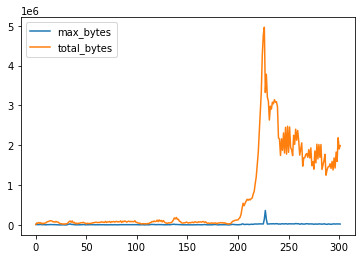

In [ ]:
dfr[['max_bytes', 'total_bytes']].plot()

<AxesSubplot:>

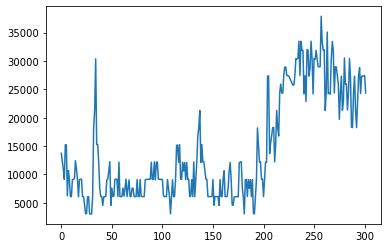

In [ ]:
dfr[dfr['max_bytes'] < 50000]['max_bytes'].plot()#(kind='hist', bins=100)

<AxesSubplot:>

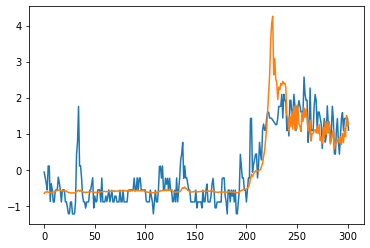

In [ ]:
mb = dfr[dfr['max_bytes'] < 50000]['max_bytes']
((mb - mb.mean())/mb.std()).plot()
tb = dfr['total_bytes']
((tb - tb.mean())/tb.std()).plot()

In [ ]:
dfr.shape

(302, 33)

In [ ]:
# ddf = dd.from_pandas(dfr, npartitions=8)
# ddf
# ddf.apply(lambda x: max_bytes(x['packet_times'],x['packet_sizes']),axis=1).compute()

,Time,IP1,Port1,IP2,Port2,Proto,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts,packet_times,packet_sizes,packet_dirs,event,drop_unix,latency,loss,later_latency,later_loss,deterministic,total_bytes,total_pkts,pkt sum,longest_seq,mean_tdelta,max_tdelta,number_ms,max_bytes,total_pkt_sizes,pkt_ratio,time_spread,byte_ratio,prediction
npartitions=8,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,int64,object,int64,object,int64,int64,int64,int64,int64,int64,object,object,object,object,object,int64,int64,int64,int64,bool,int64,int64,int64,int64,float64,int64,int64,int64,int64,float64,int64,float64,float64
38,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


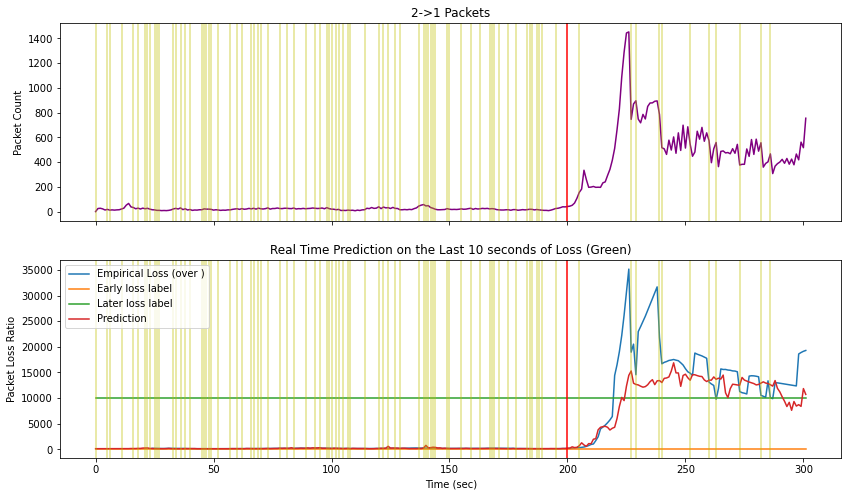

In [76]:

## PLOTTING
fig, ax = plt.subplots(2, sharex=True,figsize=(14,8))
    # fig, ax = plt.figure(figsize=(14,8))
    
def emp_loss(df, window=20):
    return (df['total_pkts'].rolling(window).sum() / 
        df['event'].str.replace('switch', '').str.split(';').str.len().fillna(0).rolling(window).sum())

ax[1].plot(emp_loss(dfr, windowsize))

emploss15s = (df['total_pkts'].rolling(15).sum().astype(np.double) / 
    df['event'].str.replace('switch', '').str.split(';').str.len().fillna(0).rolling(15).sum().astype(np.double))#.ffill()
# ax[1].plot(emploss20s)
# ax[1].plot(emploss15s)
ax[1].plot(dfr[['loss', 'later_loss', 'prediction']])
ax[0].plot(dfr[['2->1Pkts']], color='purple')
ax[0].axvline(x=shift_time, color='r')
ax[1].axvline(x=shift_time, color='r')
ax[0].set_title('2->1 Packets')
ax[1].set_title('Real Time Prediction on the Last 10 seconds of Loss (Green)')
ax[1].set_xlabel('Time (sec)')
ax[0].set_ylabel('Packet Count')
ax[1].set_ylabel('Packet Loss Ratio')
ax[1].legend(['Empirical Loss (over )','Early loss label', 'Later loss label', 'Prediction'], loc='upper left')
for i in dfr[~dfr['event'].isnull()].index:
    ax[0].axvline(x=i, color='y', alpha=.45)
    ax[1].axvline(x=i, color='y', alpha=.45)

100


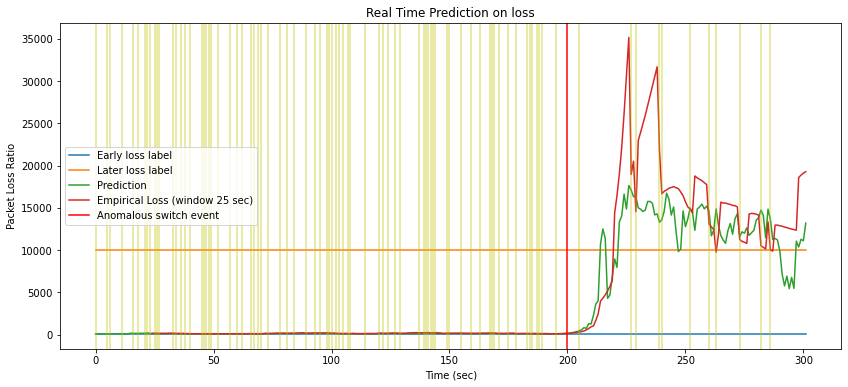

In [110]:
def plot_model_predictions(df, label='loss', windowsize=25, shift_time=180):
    '''requires a dataframe merged with with losslog data, plots its shifttime'''

    df = df.copy()
    if(label=='loss'):
        # latency features
        indexcol = ['byte_ratio', 'pkt_ratio', 'time_spread', 'total_bytes', '2->1Pkts']
    else:
        # loss features
        indexcol = ['total_pkts', 'total_pkt_sizes', '2->1Bytes', 'number_ms', 'mean_tdelta', 'max_tdelta'] 
        
    # print(len(indexcol),df[[x for x in indexcol if x in df.columns]])
    ct = pd.read_csv('outputs/combined_transform.csv').rename(
    {'mean_tdelta.1': 'mean_tdelta_amin', 'mean_tdelta.2':'mean_tdelta_amax'}, 
    axis=1)

    X_train, X_test, y_train, y_test = train_test_split(
        ct[[x for x in indexcol if x in df.columns]], ct[label_col])
    # print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    etree = RandomForestRegressor(n_estimators=100, n_jobs=4)
    etreeft = etree.fit(X_train,y_train)

    df['prediction'] = etree.predict(df[indexcol].rolling(10).mean().bfill()) # prediction

    # fig = plt.figure()
    print(df[label].values[0])
    def emp_loss(df, window=25):
        '''returns empirical loss over a window of time.'''
        return (df['total_pkts'].rolling(window).sum() / 
            df['event'].str.replace('switch', '').str.split(';').str.len().fillna(0).rolling(window).sum())


    df[['loss', f'later_{label}', 'prediction']].plot()
    emp_loss(dfr, windowsize).plot(figsize=(14,6), title=f'Real Time Prediction on {label}', xlabel='Time (sec)', ylabel='Packet Loss Ratio')
    plt.axvline(x=shift_time, color='r')

    plt.legend([
        'Early loss label', 
        'Later loss label', 
        'Prediction',
        f'Empirical Loss (window {windowsize} sec)',
        'Anomalous switch event'
        ], loc='center left')
    for i in df[~df['event'].isnull()].index:
        plt.axvline(x=i, color='y', alpha=.45)
    path = os.path.join(os.getcwd() , "outputs")
    saveto = os.path.join(path, "eda",f'{label}_model_preds.png')
    plt.savefig(saveto)
plot_model_predictions(dfr, shift_time=200)

In [96]:
df['later_label']

KeyError: 'later_label'

In [ ]:
df['event'].unique()

array(['drop', nan, 'drop;drop', 'drop;drop;drop'], dtype=object)

In [ ]:
df.columns

Index(['Time', 'IP1', 'Port1', 'IP2', 'Port2', 'Proto', '1->2Bytes',
       '2->1Bytes', '1->2Pkts', '2->1Pkts', 'packet_times', 'packet_sizes',
       'packet_dirs', 'event', 'drop_unix', 'latency', 'loss', 'later_latency',
       'later_loss', 'deterministic', 'total_bytes', 'total_pkts', 'pkt sum',
       'longest_seq', 'mean_tdelta', 'max_tdelta', 'number_ms', 'max_bytes',
       'total_pkt_sizes', 'pkt_ratio', 'time_spread', 'byte_ratio'],
      dtype='object')

<AxesSubplot:>

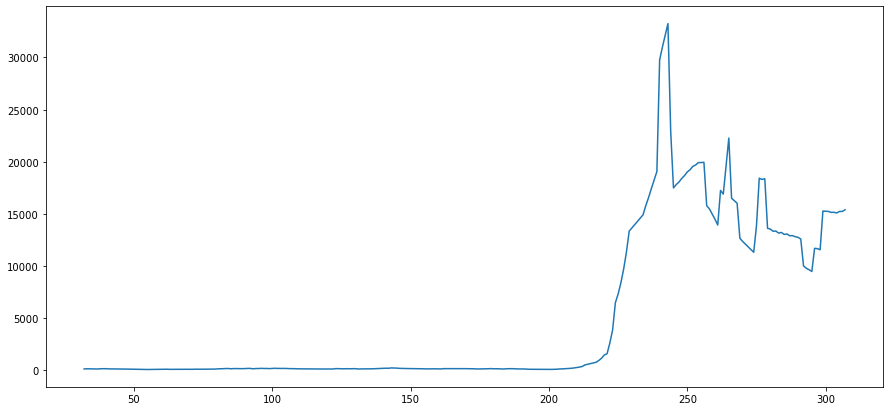

In [ ]:
emploss30s = (df['total_pkts'].rolling(30).sum().astype(np.double) / 
    df['event'].str.replace('switch', '').str.split(';').str.len().fillna(0).rolling(30).sum().astype(np.double))#.ffill()
emploss30s[(emploss10s < 20000) & (emploss30s != np.nan)].plot(figsize=(15,7))#(kind='hist', figsize=(15,7), bins=40)

<AxesSubplot:ylabel='Frequency'>

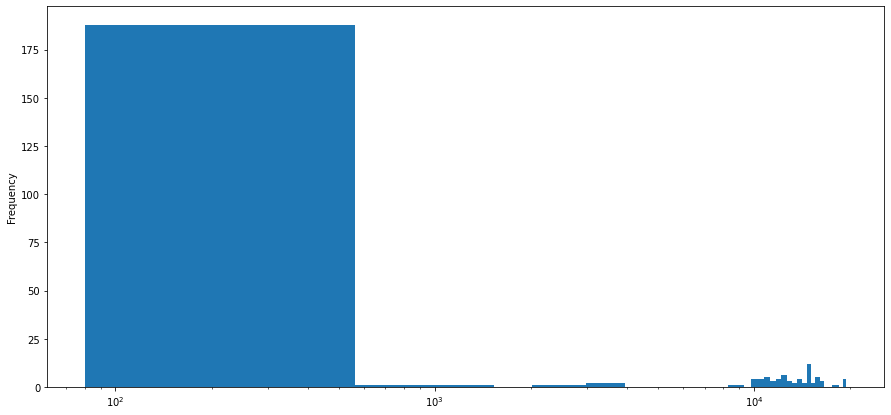

In [41]:
emploss20s = (df['total_pkts'].rolling(20).sum() / 
    df['event'].str.replace('switch', '').str.split(';').str.len().fillna(0).rolling(20).sum())#.ffill()
emploss20s[(emploss20s < 20000) & (emploss20s != np.nan)].plot(kind='hist', figsize=(15,7), logx=True, bins=40)



<AxesSubplot:>

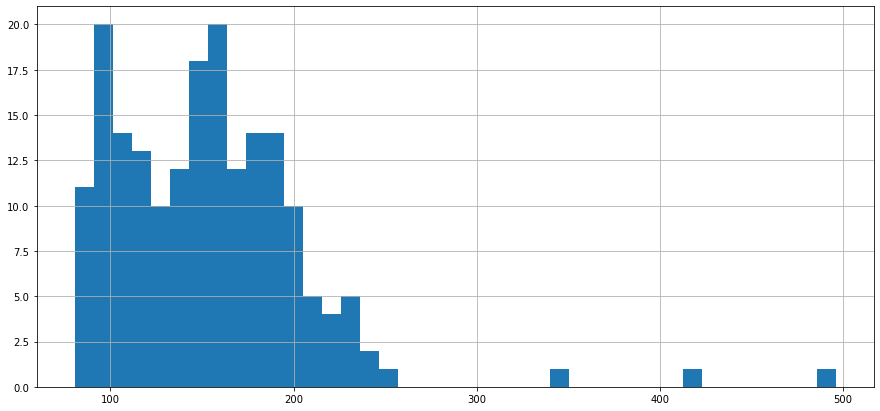

In [ ]:
emploss20s[(emploss20s < 500) & (emploss20s != np.nan) & (emploss20s != 0)].hist(figsize=(15,7), bins=40)

<AxesSubplot:>

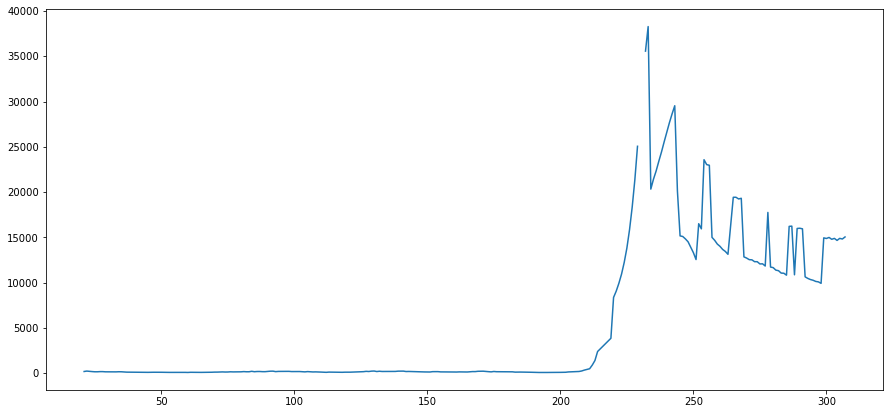

- empirical loss, maybe we can plot that
- maybe split timedelta directionally
- byte ratio is a good feature yep, same with packet ratio
- PCA funkyyyyyyyy


which approach to continue with?
forecasting, clustering

arima: an hour of dane 

In [ ]:
filename='data/jennawk5data/20220201T010740_200-100-true-200-10000-200-iperf.csv'
losslog_dir = 'data/jennawk5data'
run_labels = filename.split('_')[-1].split('-')[:-1]
temp_label_str = '-'.join(run_labels) 
losslog = f'{losslog_dir}/losslog-{temp_label_str}.csv' #losslog filename str

run_df = pd.read_csv(filename)
losslog_df = pd.read_csv(losslog, header=None).rename(
    columns={0:'event', 1:'drop_unix', 2:'IP1', 3:'Port1', 4:'IP2', 5:'Port2', 6:'Proto'}).fillna(-1)
losslog_df['Time'] = losslog_df['drop_unix'].astype(int)
grouped = losslog_df.groupby(['Time', 'IP1', 'Port1', 'IP2', 'Port2', 'Proto']
                             ).agg(lambda x: ';'.join(x.astype(str)) if len(x) > 1 else x.astype(str)).reset_index()
grouped['event'].unique()


array(['drop', 'drop;drop', 'drop;drop;drop', 'switch'], dtype=object)

## fix groupby and the join method in the actual readfilerun function

In [ ]:
run_df[run_df['Time'] == 1643677855]

,Time,IP1,Port1,IP2,Port2,Proto,1->2Bytes,2->1Bytes,1->2Pkts,2->1Pkts,packet_times,packet_sizes,packet_dirs
200,1643677855,192.168.96.3,47330,192.168.48.2,5001,6,97500,1460,65,26,1643677855044;1643677855044;1643677855044;1643...,52;1500;1500;52;1500;1500;52;1500;1500;1500;15...,2;1;1;2;1;1;2;1;1;1;1;1;1;2;1;1;2;1;1;2;1;1;1;...


In [42]:
dfr['emp_loss'] = emploss20s

In [46]:
(dfr['emp_loss'].bfill() - dfr['prediction'])

0        88.821429
1        88.821429
2        88.821429
3        88.821429
4        88.821429
          ...     
297    1665.166667
298    1228.666667
299    6587.000000
300    3046.000000
301    4293.000000
Length: 302, dtype: float64

<AxesSubplot:>

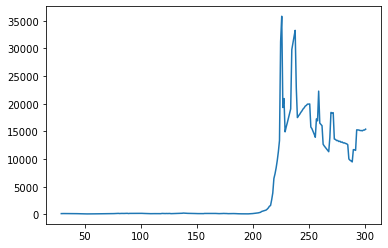

In [55]:
df.columns

Index(['Time', 'IP1', 'Port1', 'IP2', 'Port2', 'Proto', '1->2Bytes',
       '2->1Bytes', '1->2Pkts', '2->1Pkts', 'packet_times', 'packet_sizes',
       'packet_dirs', 'event', 'drop_unix', 'latency', 'loss', 'later_latency',
       'later_loss', 'deterministic', 'total_bytes', 'total_pkts', 'pkt sum',
       'longest_seq', 'mean_tdelta', 'max_tdelta', 'number_ms', 'max_bytes',
       'total_pkt_sizes', 'pkt_ratio', 'time_spread', 'byte_ratio'],
      dtype='object')

In [56]:
df['event'].unique()

array(['drop', nan, 'drop;drop', 'drop;drop;drop'], dtype=object)

In [1]:
lst = list(range(4))
lst

[0, 1, 2, 3]

In [4]:
lst[2:]

[2, 3]

In [21]:
filename= 'data\\jennawk5data\\20220201T010740_200-100-true-200-10000-200-iperf.csv'
run_labels = filename.split('_')[-1].split('-')[:-1]
temp_label_str = '-'.join(run_labels) 
run_labels[5:]
    

['200']

In [45]:
d = readfilerun_simple(filename, 'data\\jennawk5data')
d['event'].unique()

array(['drop', nan, 'drop;drop', 'drop;drop;drop', 'drop;switch'],
      dtype=object)

In [46]:
d[d['event'].str.contains('switch') == True].index[0]

200

In [53]:
after_switch = d['event'].str.contains('switch').replace(False, np.nan).ffill().fillna(False)
d['loss'][after_switch] = d['later_loss']
d['latency'][after_switch] = d['later_latency']

0      False
1      False
2      False
4      False
5      False
       ...  
303     True
304     True
305     True
306     True
307     True
Name: event, Length: 302, dtype: bool

<AxesSubplot:>

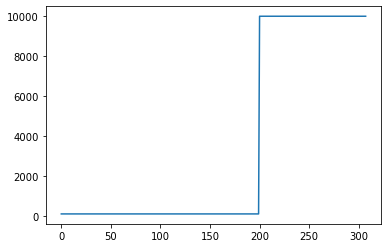

In [55]:
d['loss'][is_switch] = d['later_loss']
d['loss'].plot()

classification problem" los function of minimizing number of false positives while still figuring out the actual latency switch